In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
import pandas as pd
#!mkdir generated_mnist
#!mkdir original_mnist

In [2]:
BATCH_SIZE=128
LEARNING_RATE=2e-4
LATENT_DIM=100

In [3]:
(X_train,_),(X_test,_)=datasets.mnist.load_data()

In [4]:
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
dataset=np.concatenate((X_train,X_test),axis=0)

In [6]:
dataset=np.expand_dims(dataset,-1).astype('float32')

In [7]:
train_dataset=tf.data.Dataset.from_tensor_slices(dataset)

In [8]:
def preprocess(image):
    return tf.cast(image,tf.float32)/127.5-1.0

In [9]:
train_dataset=train_dataset.map(preprocess).shuffle(1024,reshuffle_each_iteration=True).batch(BATCH_SIZE,drop_remainder=True).prefetch(tf.data.AUTOTUNE)

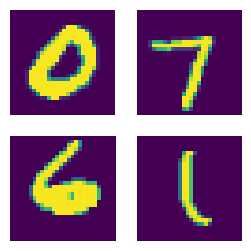

In [10]:
# Let's check how the original dataset looks like
first_batch=iter(train_dataset).get_next()
plt.figure(figsize=(3,3))
k=1
while k<5:
    plt.subplot(2,2,k)
    plt.imshow((first_batch[k-1]+1)/2)
    plt.axis('off')
    k+=1

##### Set up the model

In [11]:
### Generator
generator=tf.keras.Sequential([
    Input(shape=(LATENT_DIM,)),
    Dense(7*7*LATENT_DIM),
    Reshape((7,7,LATENT_DIM)),

    Conv2DTranspose(256,kernel_size=4,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128,kernel_size=4,strides=2,padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(64,kernel_size=4,strides=1,padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(1,kernel_size=2,strides=1,activation=tf.keras.activations.tanh,padding='same'),
],name='generator')

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4900)              494900    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 256)       409856    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 256)       1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       51

In [13]:
train_dataset

<PrefetchDataset shapes: (128, 28, 28, 1), types: tf.float32>

In [14]:
discriminator=tf.keras.Sequential([
    Input(shape=(28,28,1)),
    Conv2D(64,kernel_size=4,strides=2, padding='same'),
    LeakyReLU(0.2),

    Conv2D(128,kernel_size=4,strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256,kernel_size=4,strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2D(1,kernel_size=4,strides=2, padding='same'),
    Flatten(),
    Dense(1,activation='sigmoid') 
],name='discriminator')

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)       

In [16]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(8,8))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated_mnist/gen_images_epoch_{}.png".format(epoch+1))

In [17]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')
    
  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]
  
  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake
      
    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)
      
    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    
    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [18]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
546/546 [==============================] - 33s 53ms/step - d_loss: 1.2230 - g_loss: 0.7527
Epoch 2/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2433 - g_loss: 0.7527
Epoch 3/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2153 - g_loss: 0.7869
Epoch 4/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.1938 - g_loss: 0.8363
Epoch 5/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.1978 - g_loss: 0.8443
Epoch 6/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2032 - g_loss: 0.8294
Epoch 7/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2099 - g_loss: 0.8231
Epoch 8/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2157 - g_loss: 0.8234
Epoch 9/50
546/546 [==============================] - 30s 54ms/step - d_loss: 1.2223 - g_loss: 0.8155
Epoch 10/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2

C:\Users\vul09\AppData\Local\Temp\ipykernel_4616\1620826118.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


Epoch 22/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2480 - g_loss: 0.7709
Epoch 23/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2518 - g_loss: 0.7664
Epoch 24/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2530 - g_loss: 0.7657
Epoch 25/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2540 - g_loss: 0.7645
Epoch 26/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2491 - g_loss: 0.7646
Epoch 27/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2510 - g_loss: 0.7704
Epoch 28/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2524 - g_loss: 0.7691
Epoch 29/50
546/546 [==============================] - 29s 54ms/step - d_loss: 1.2545 - g_loss: 0.7660
Epoch 30/50
546/546 [==============================] - 29s 53ms/step - d_loss: 1.2489 - g_loss: 0.7686
Epoch 31/50
546/546 [==============================] - 30s 54ms/step - d_

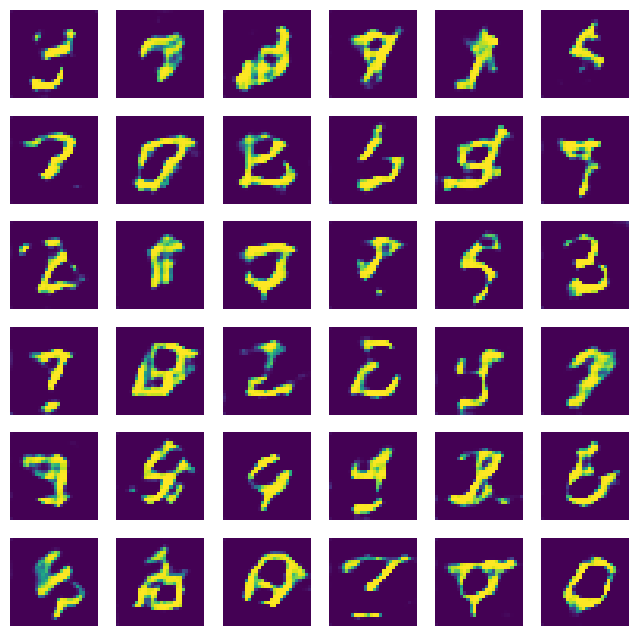

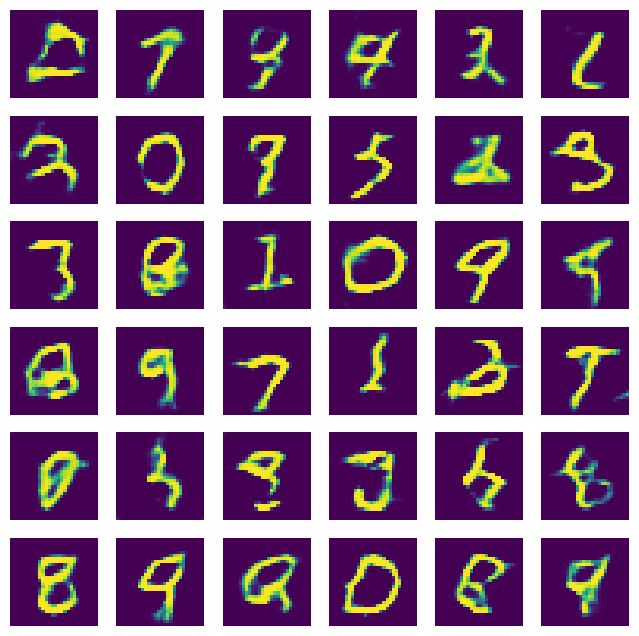

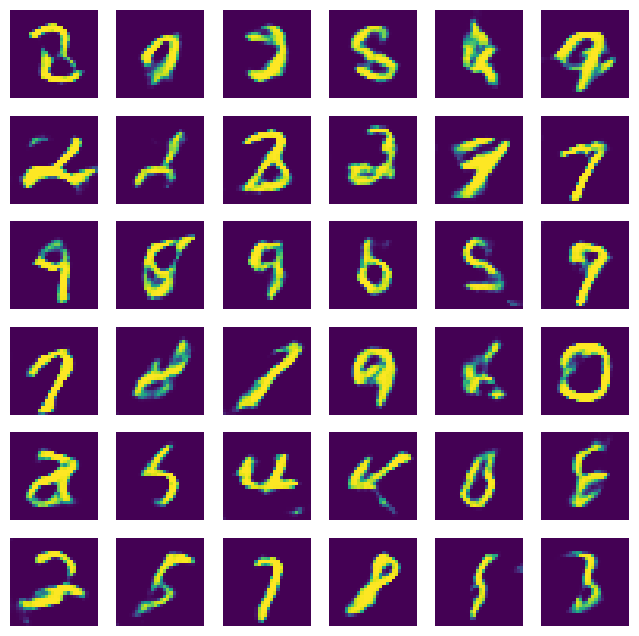

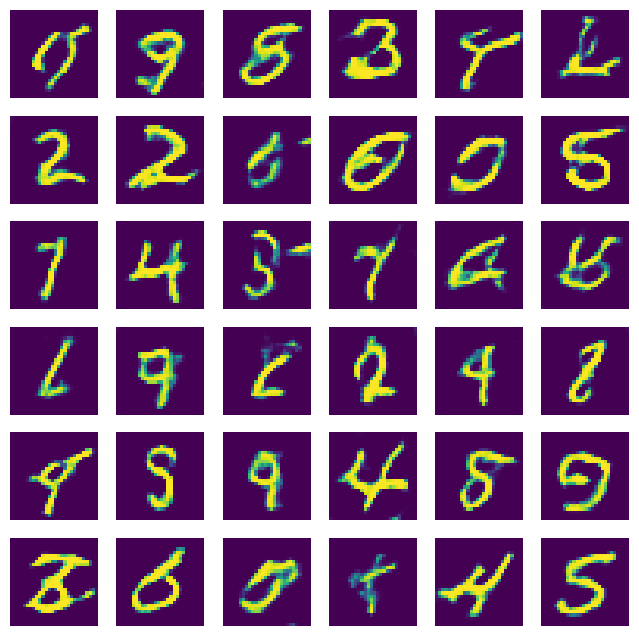

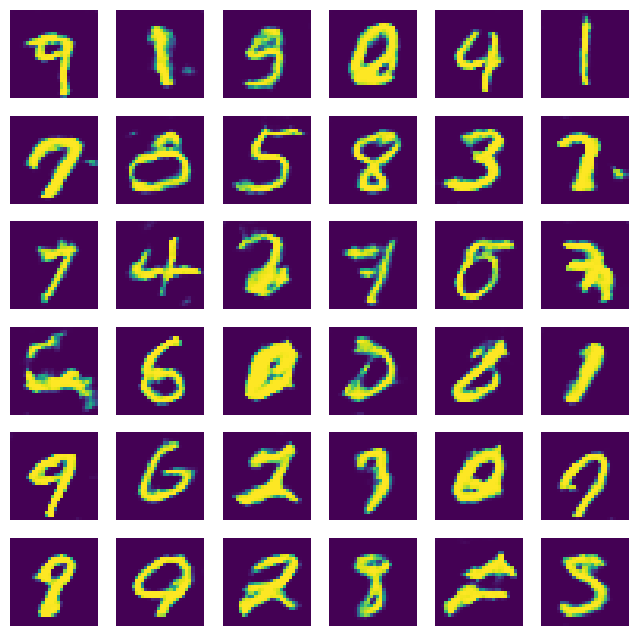

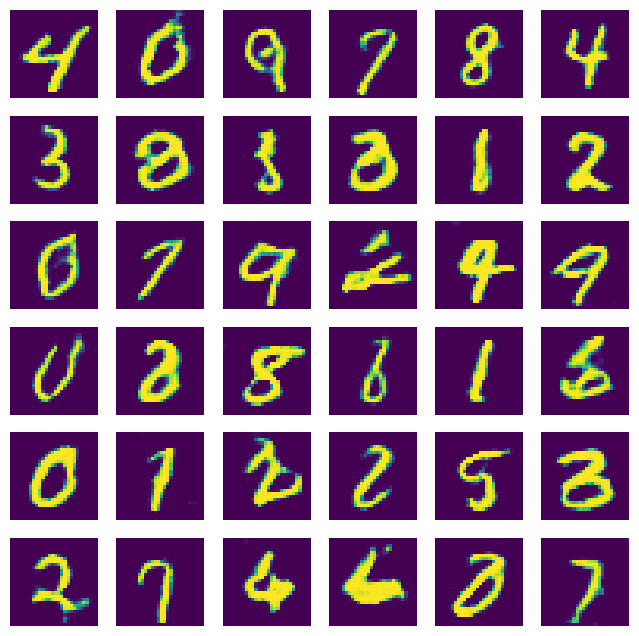

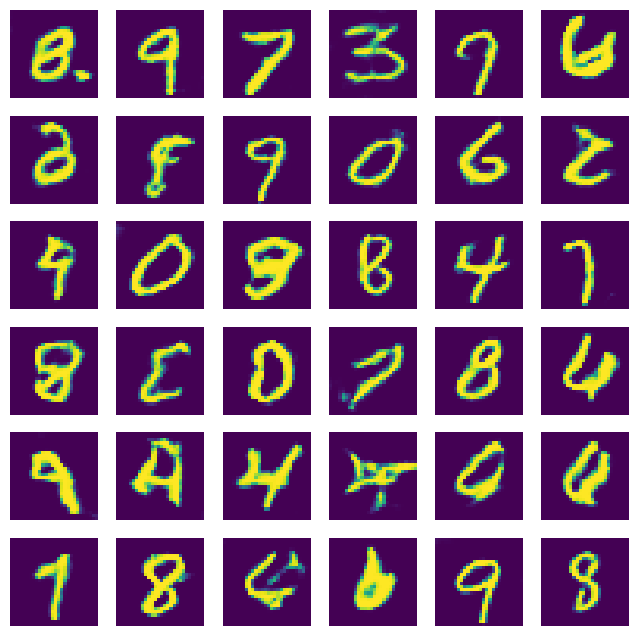

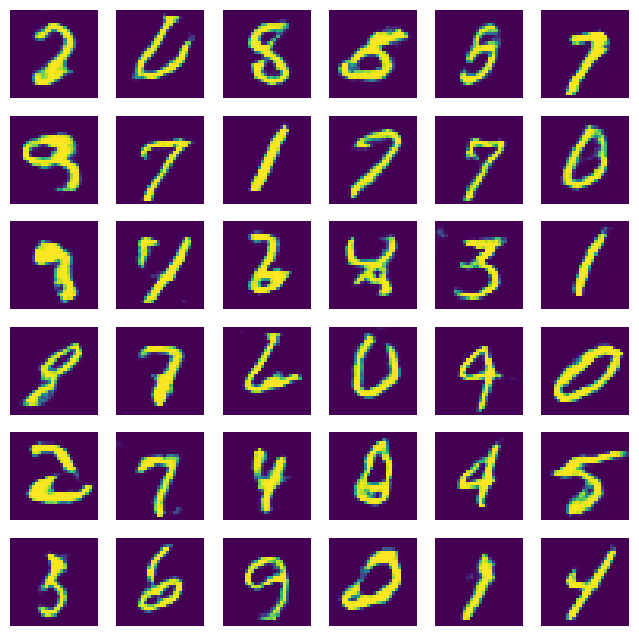

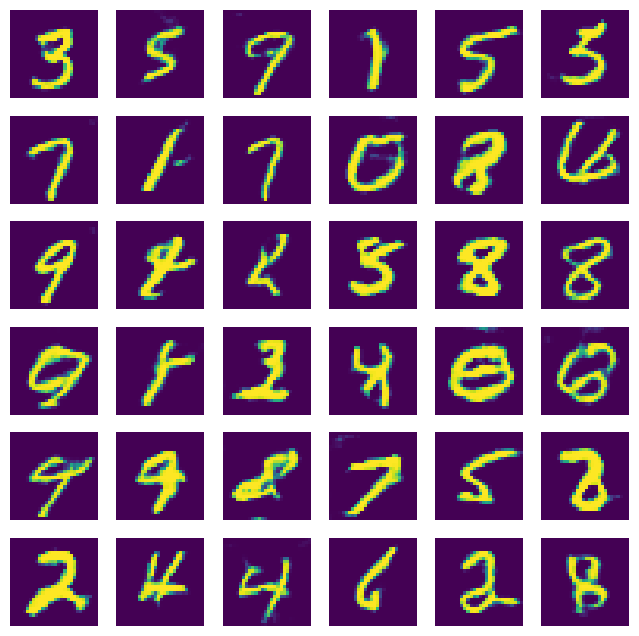

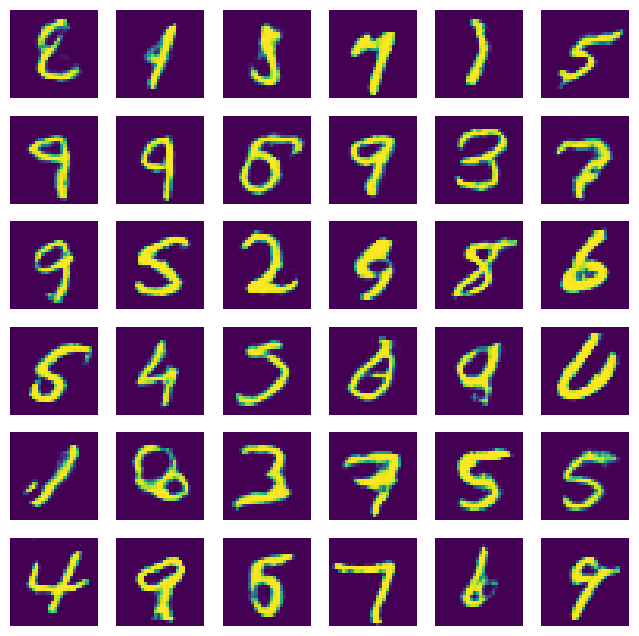

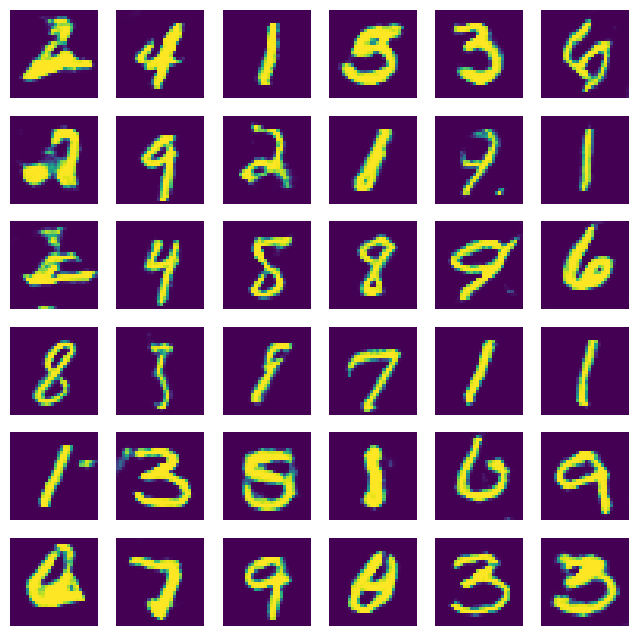

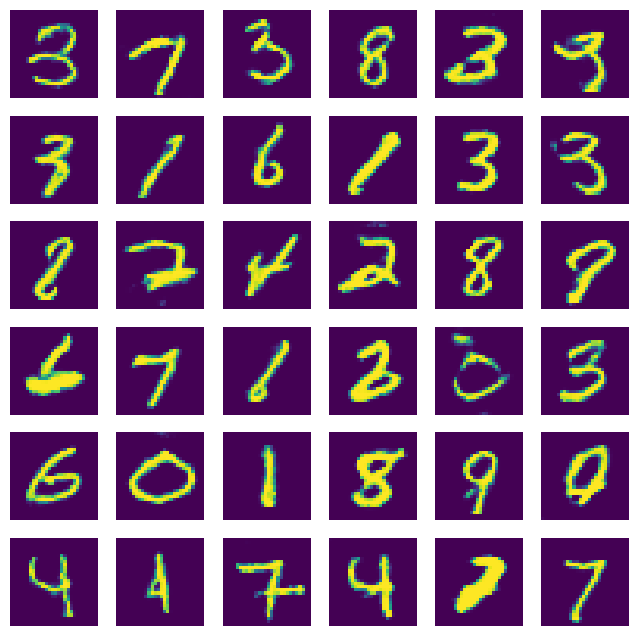

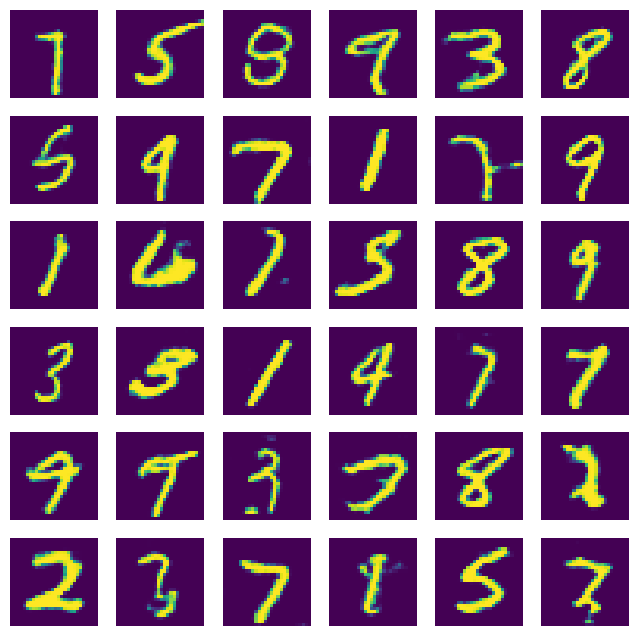

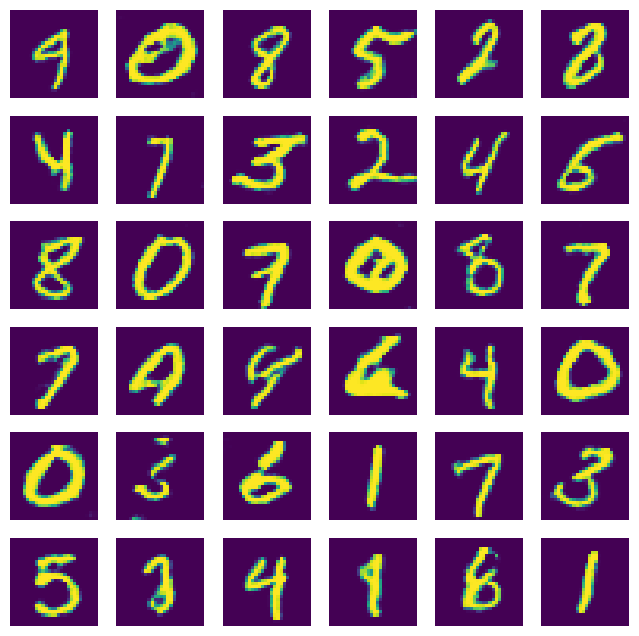

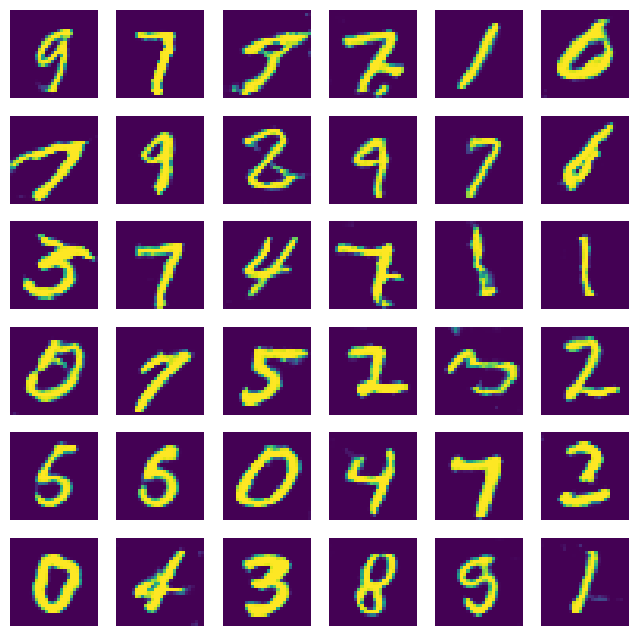

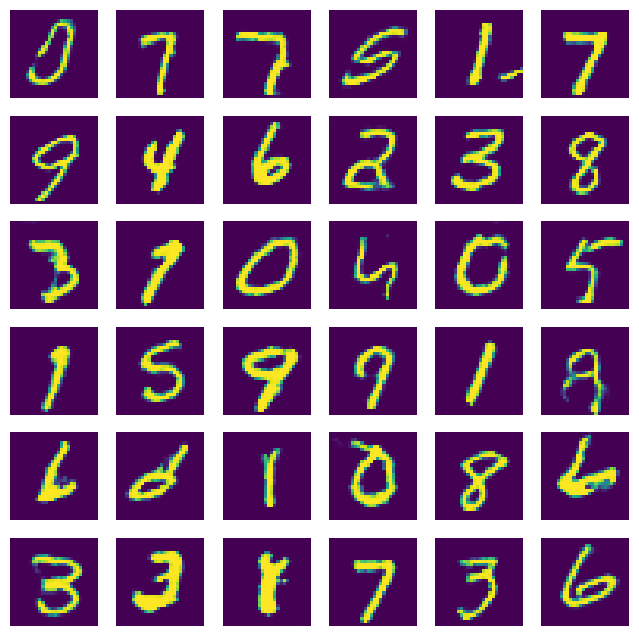

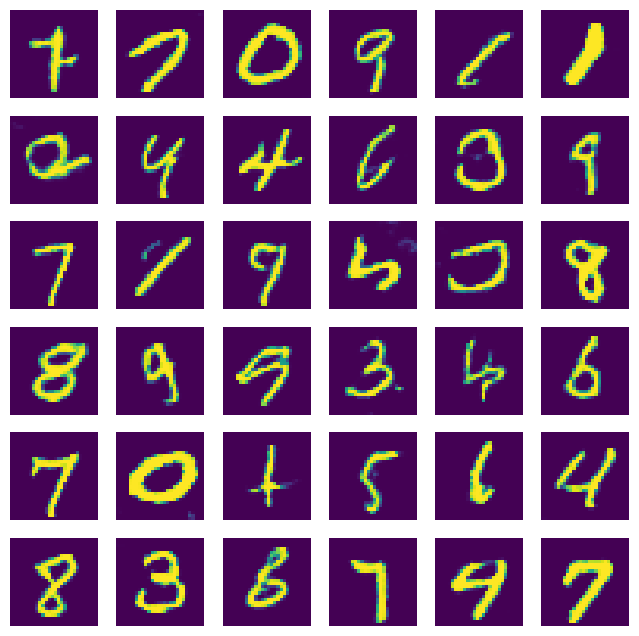

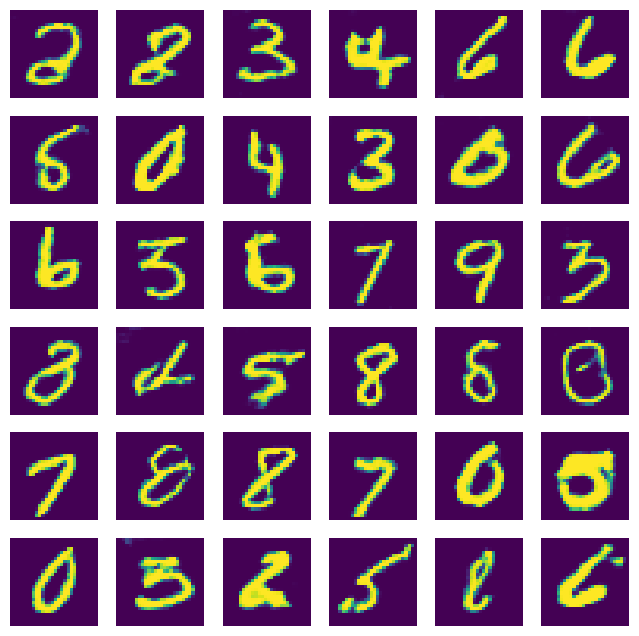

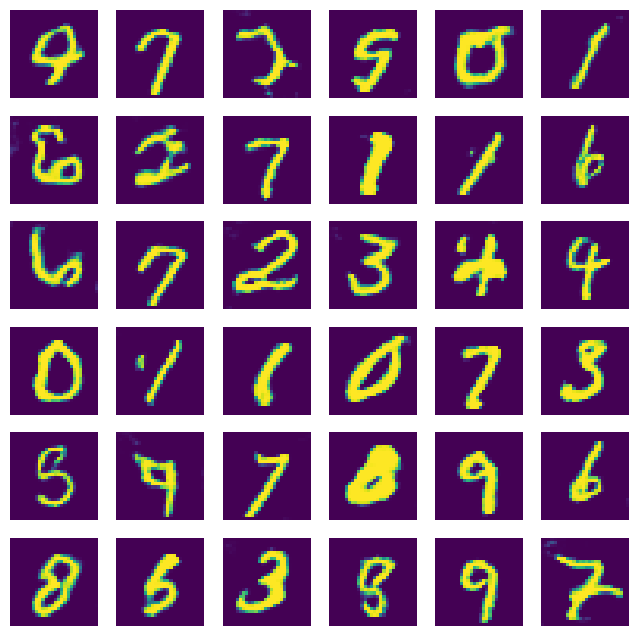

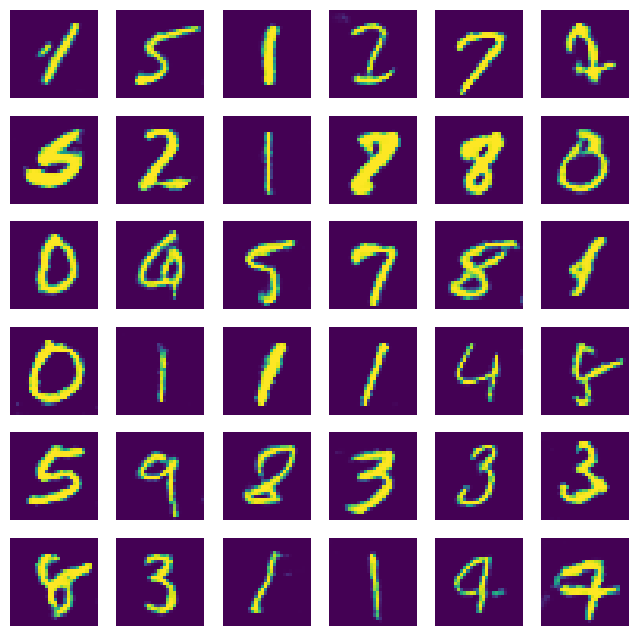

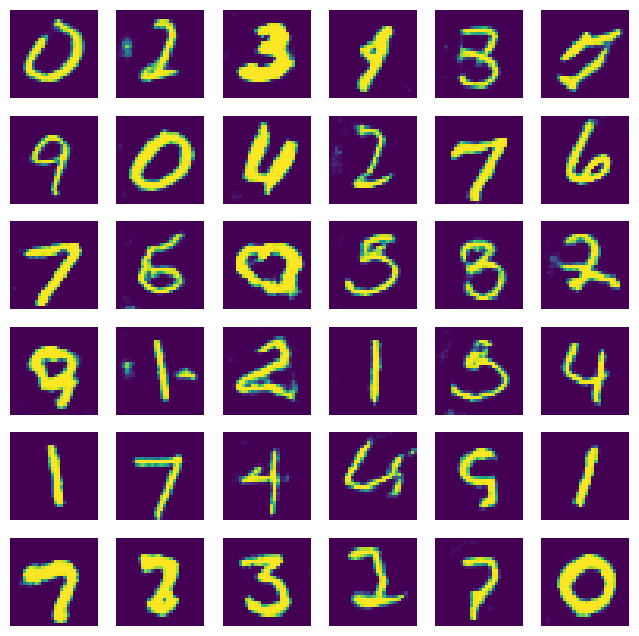

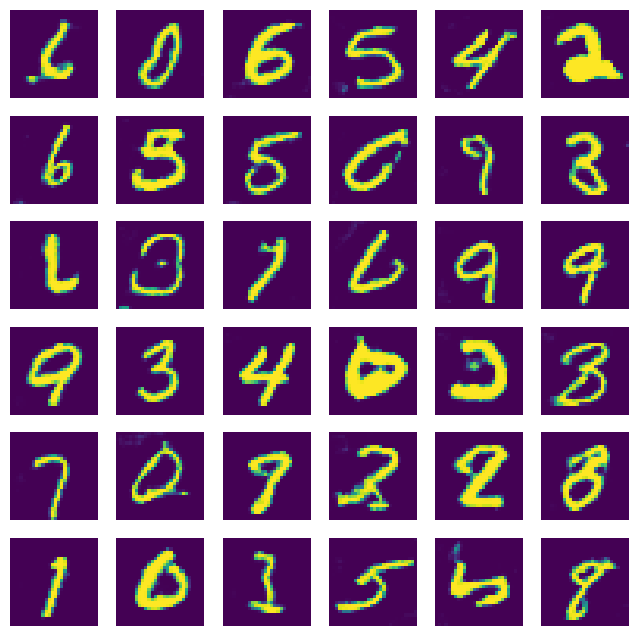

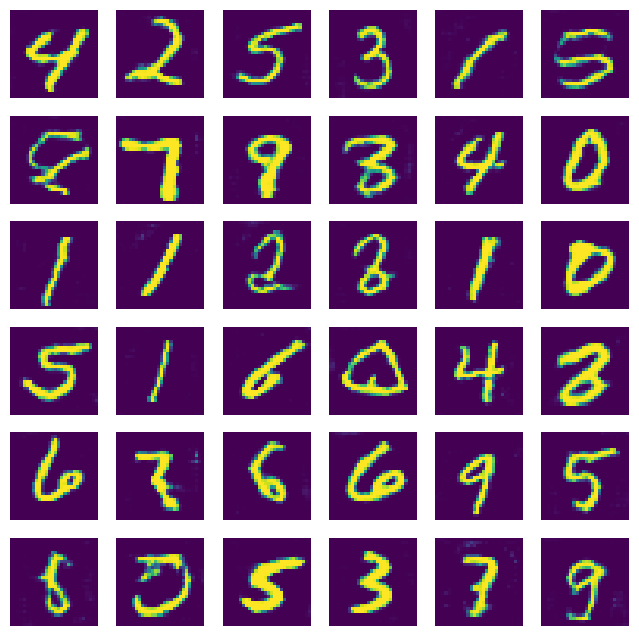

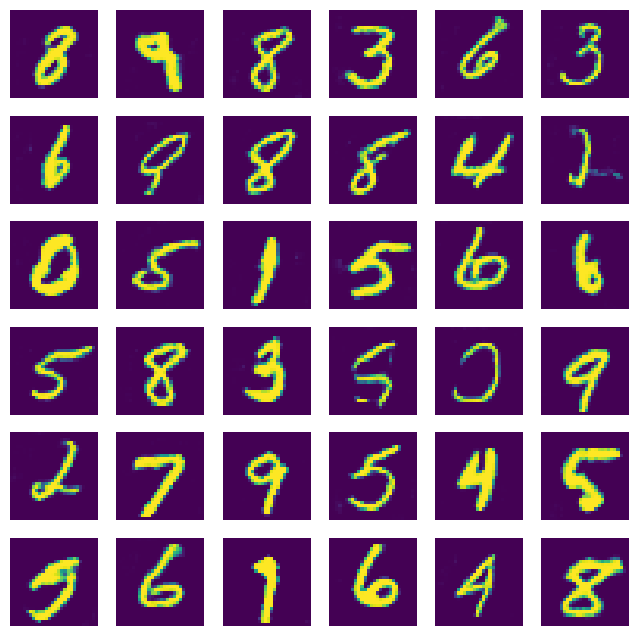

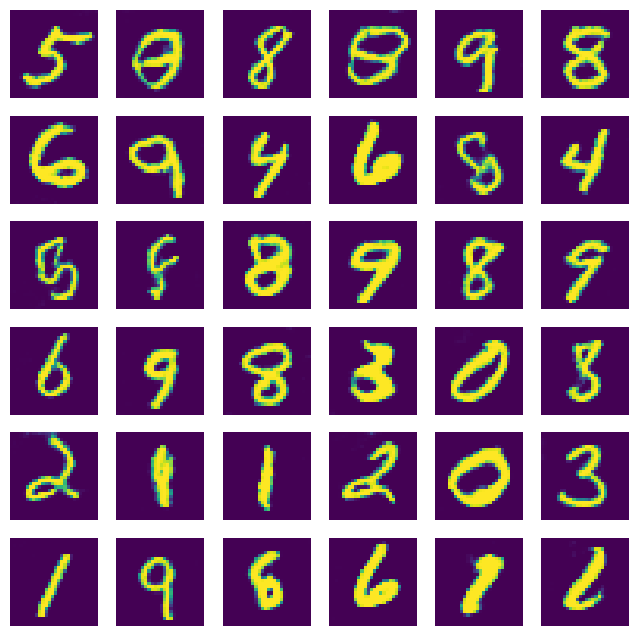

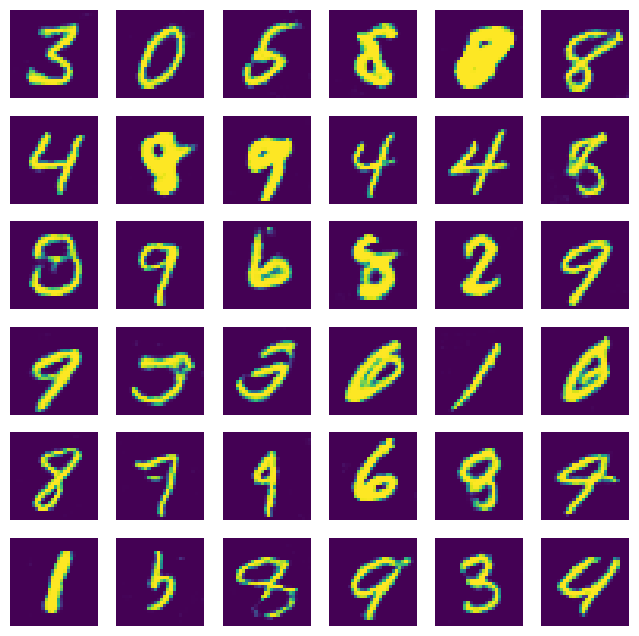

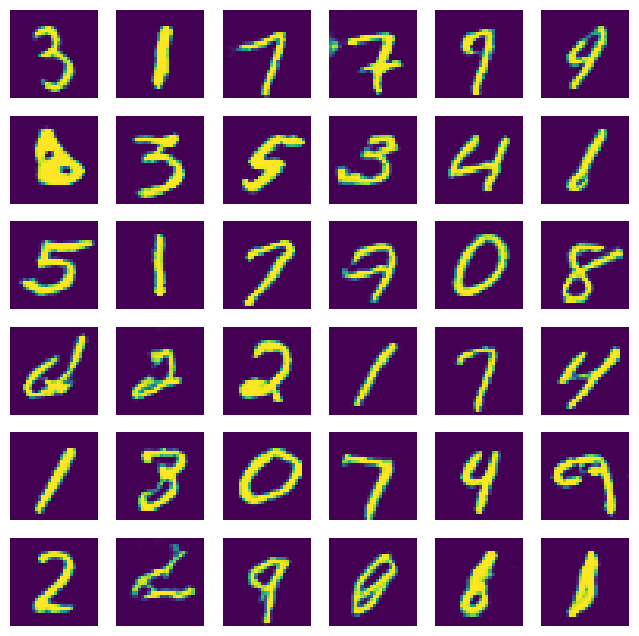

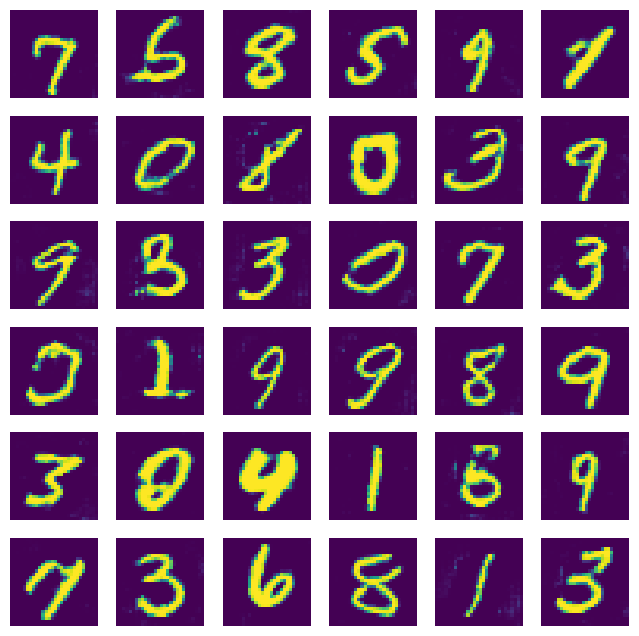

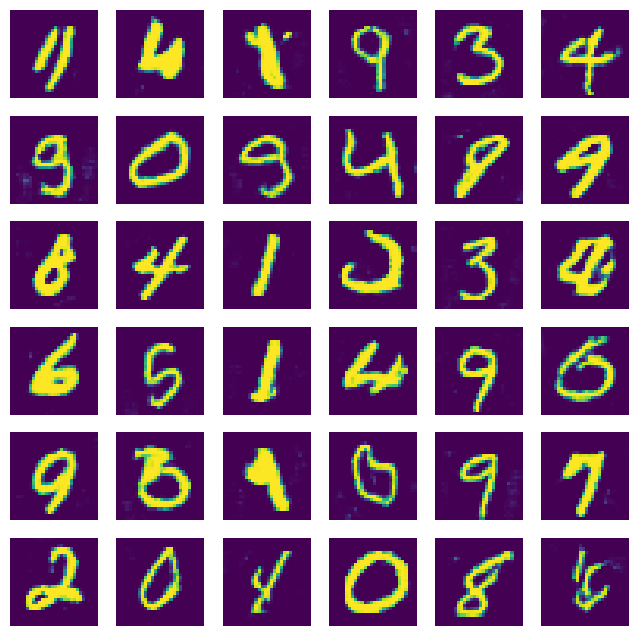

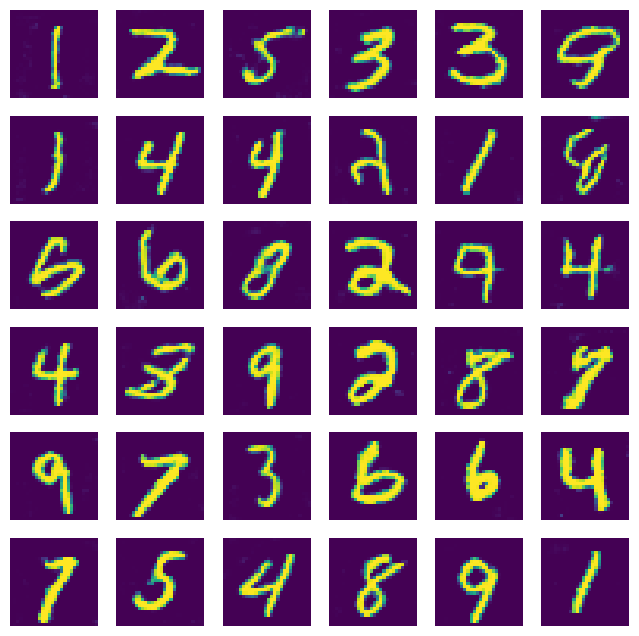

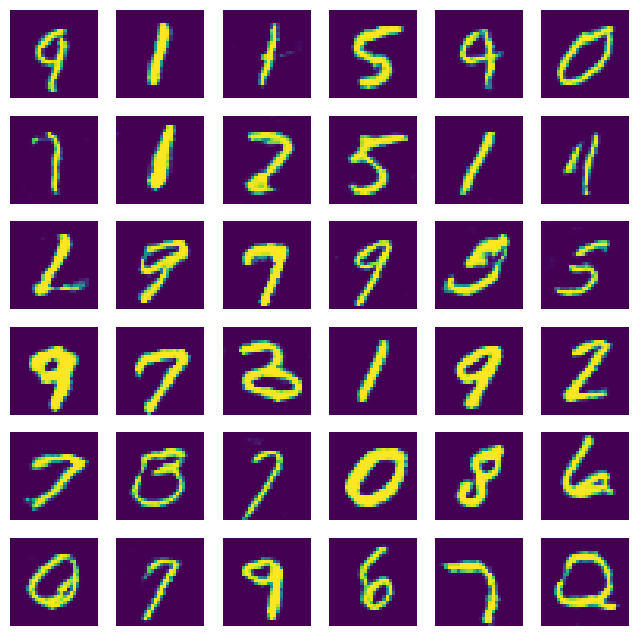

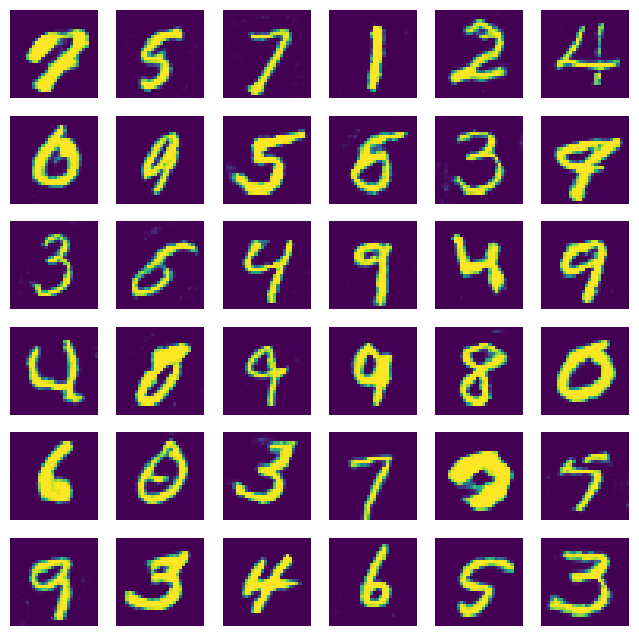

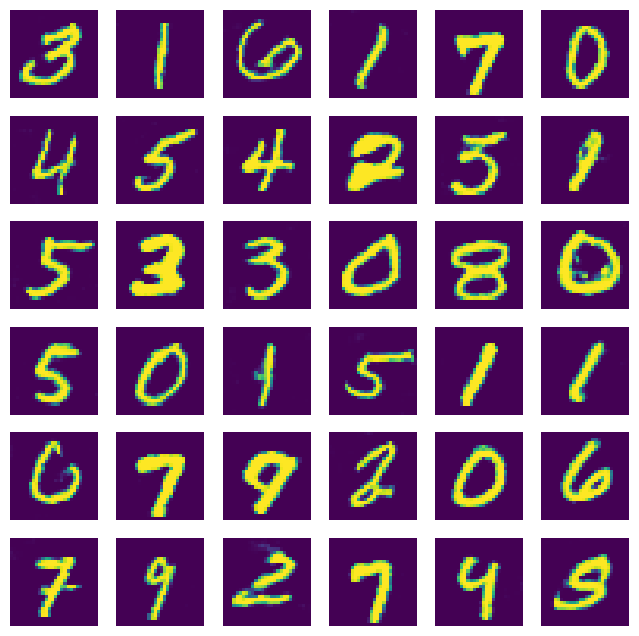

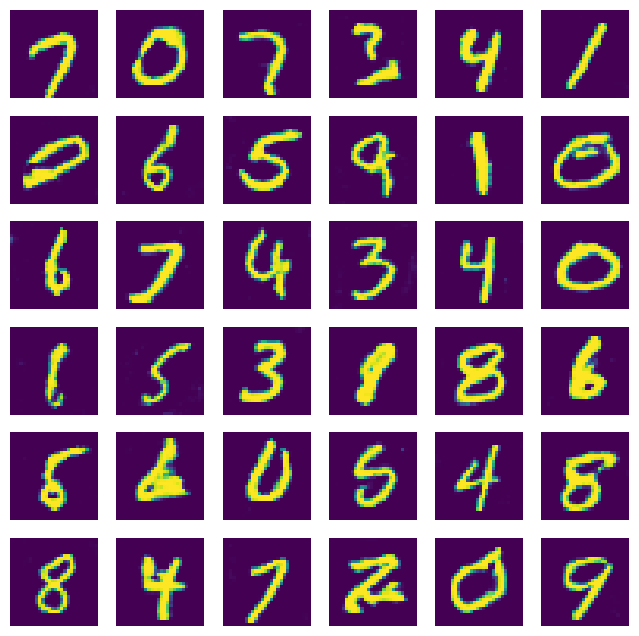

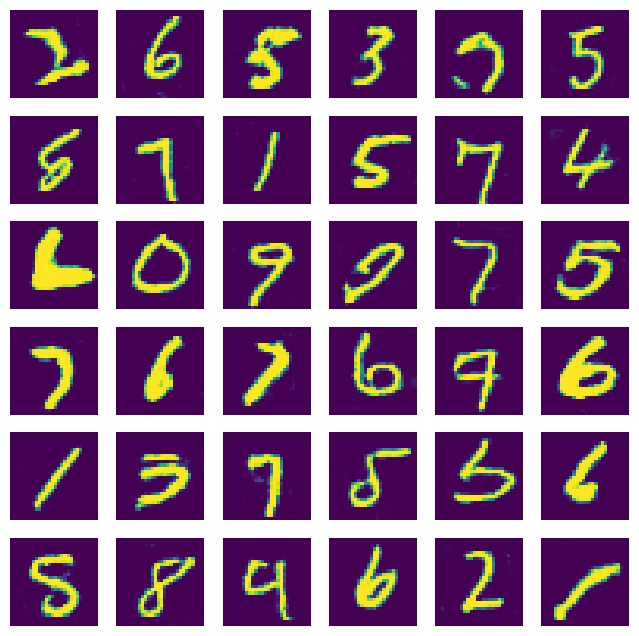

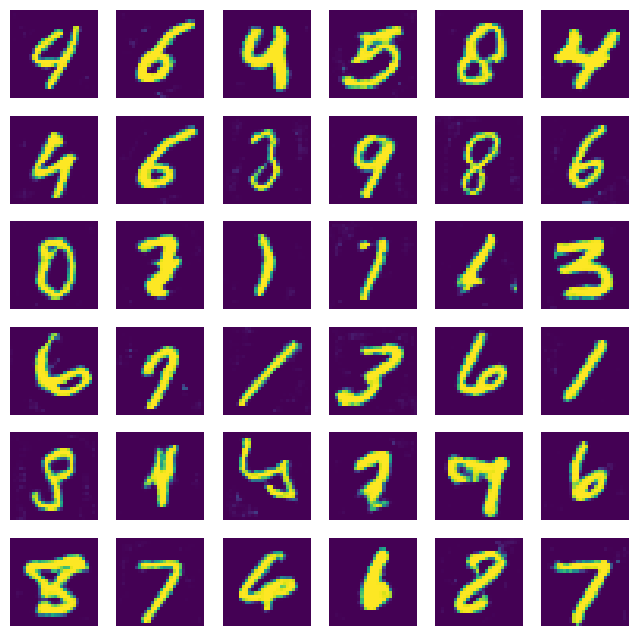

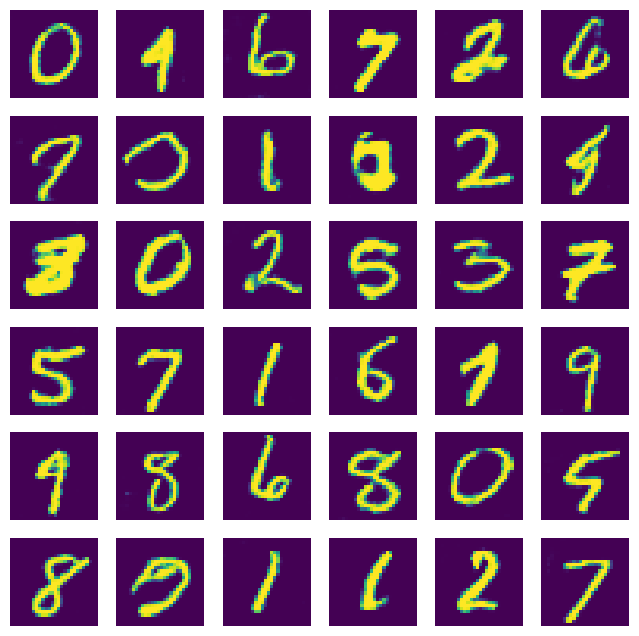

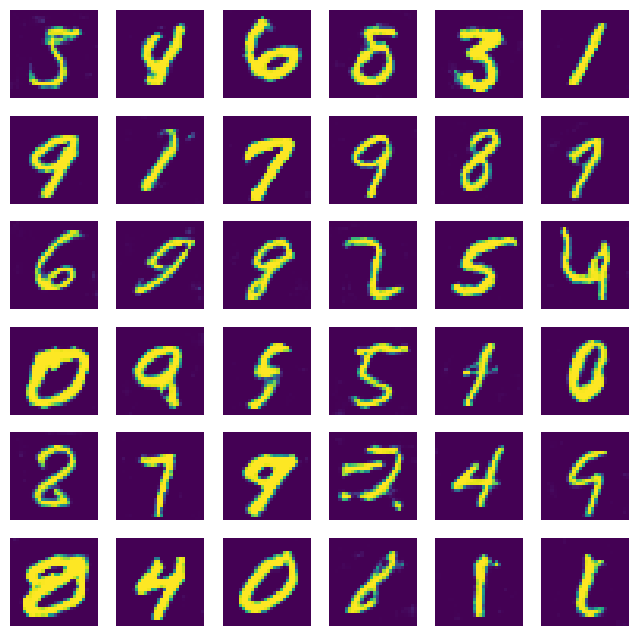

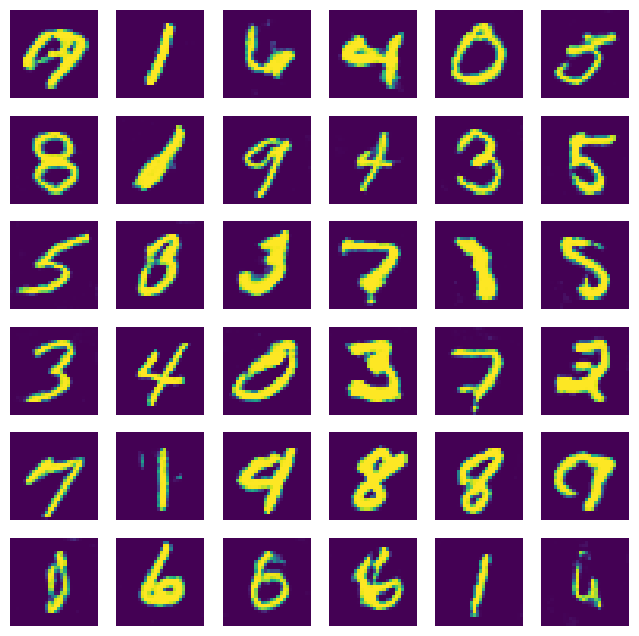

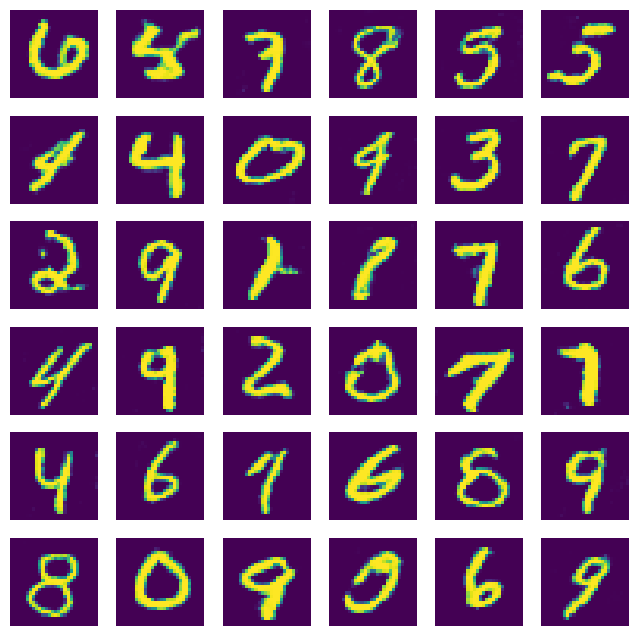

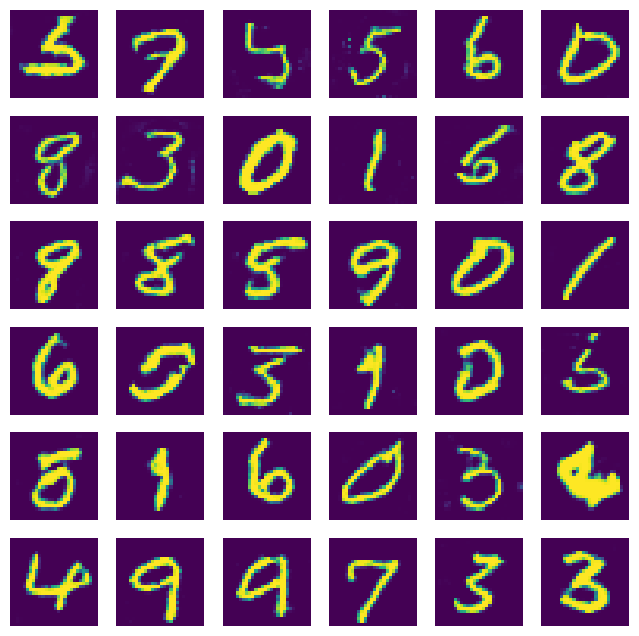

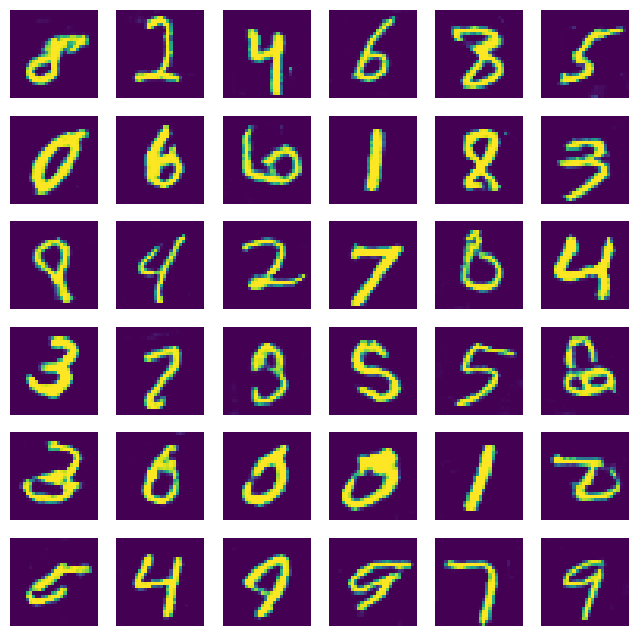

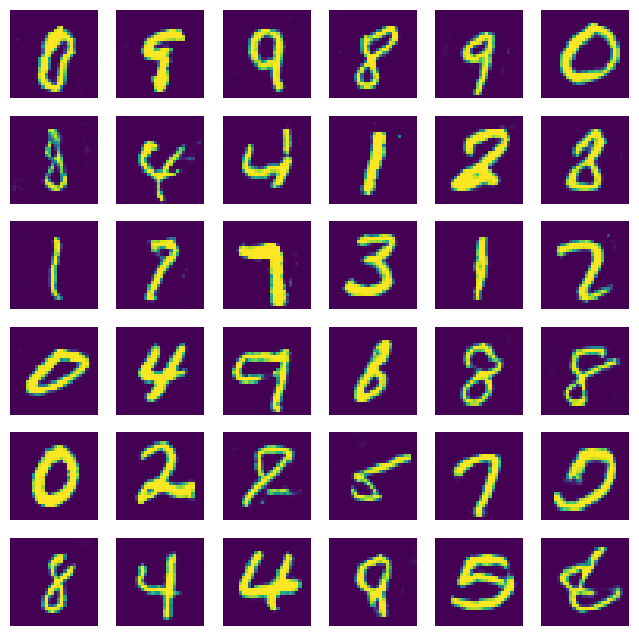

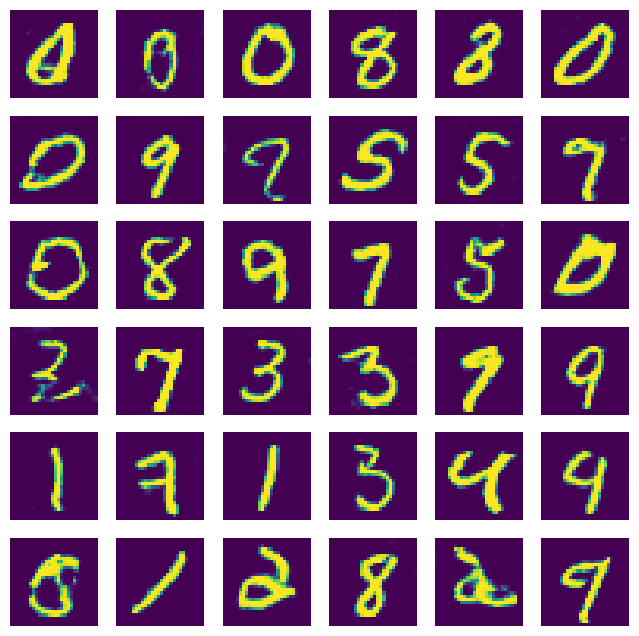

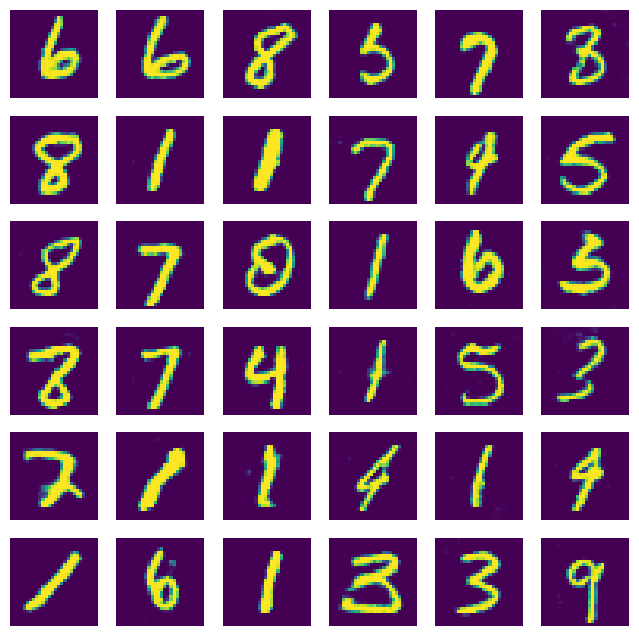

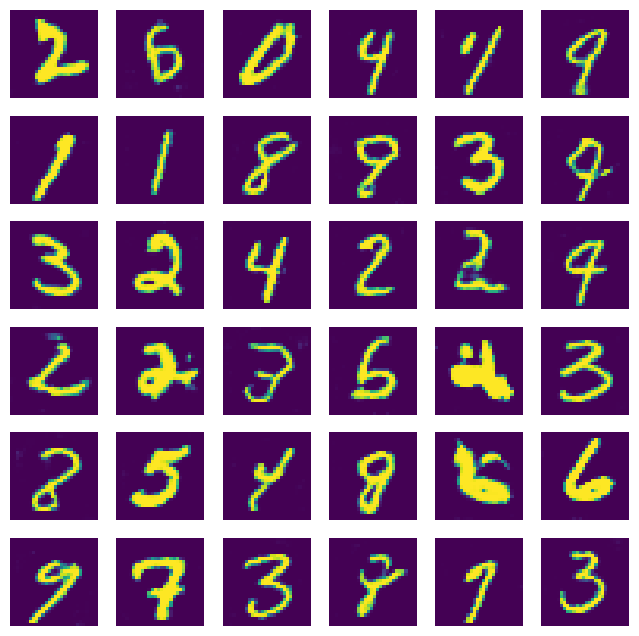

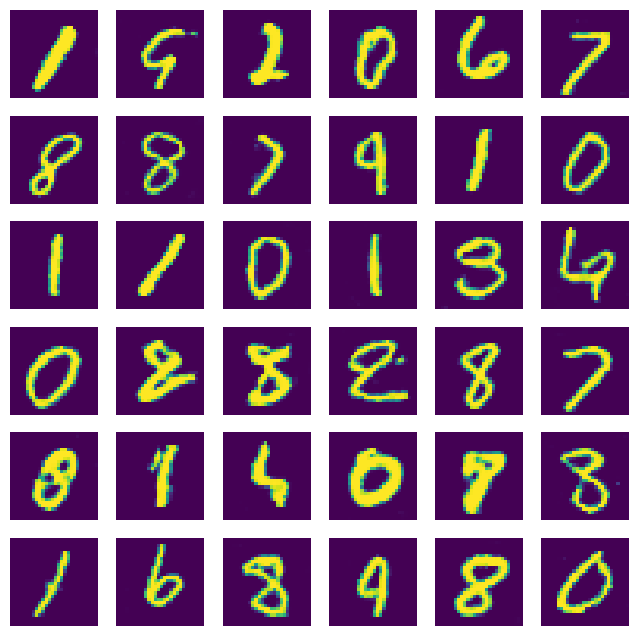

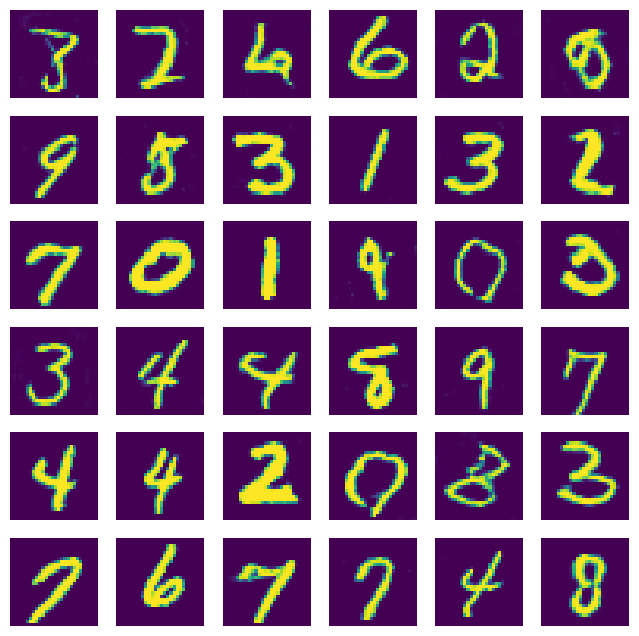

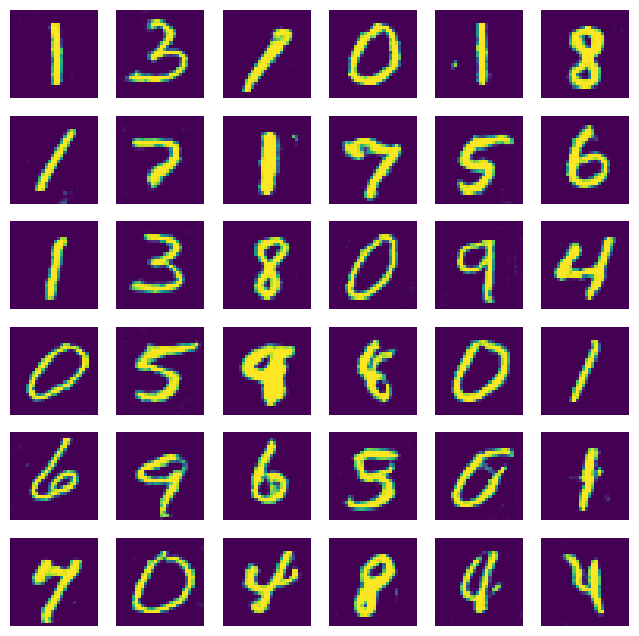

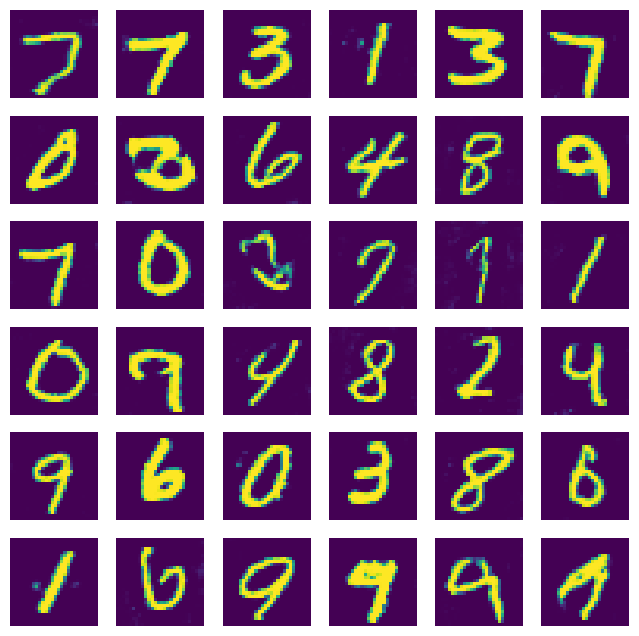

In [19]:
EPOCHS=50
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

<Axes: >

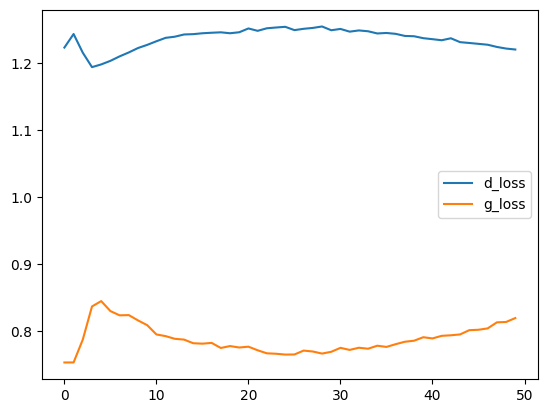

In [20]:
pd.DataFrame(history.history).plot()

In [21]:
tf.saved_model.save(gan,'mnist_gan_epochs_50')

INFO:tensorflow:Assets written to: mnist_gan_epochs_50\assets


In [22]:
import os
import re
from PIL import Image,ImageDraw,ImageFont
filenames=os.listdir('./generated_mnist')
filenames.sort(key=lambda x: int(re.findall(r'\d+',x)[0]))

In [23]:
# Save images as animation
images=[]
for file in filenames:
    img=Image.open(f'./generated_mnist/{file}')
    idx=re.findall(r'\d+',file)[0]
    T=ImageDraw.Draw(img)
    myFont=ImageFont.truetype('arial.ttf',65)
    T.text((28,28),f'epoch: {idx}',font=myFont,fill=(255,0,0))
    images.append(img)
img1=images[0]
img1.save('generated_movie2.gif',format='GIF',append_images=images,save_all=True,duration=500,loop=0)

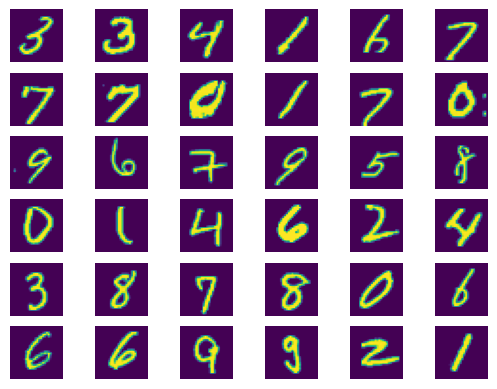

In [24]:
c=0
for data in train_dataset:
    if c==3:
        break
    else:
        k=1
        c+=1
        while k<37:
            plt.subplot(6,6,k)
            plt.imshow(data[k-1])
            plt.axis('off')
            k+=1
            plt.savefig(f"./original_mnist/original_mnist{c}.png")

In [28]:
## if we want to load model for further usage
model = tf.saved_model.load('mnist_gan_epochs_50')
random_noise=tf.random.normal(shape=(1,LATENT_DIM))
fake_imgs=model.generator(random_noise)
fake_imgs.shape

TensorShape([1, 28, 28, 1])

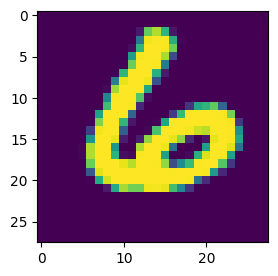

In [34]:
plt.figure(figsize=(3,3))
plt.imshow(fake_imgs[0,...])